In [8]:
import pandas as pd
import numpy as np

In [9]:
train_file_path = 'https://raw.githubusercontent.com/binay8/DataScienceProjects/master/Titanic/train.csv'
test_file_path = 'https://raw.githubusercontent.com/binay8/DataScienceProjects/master/Titanic/test.csv'

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Understand each attributes and the strategy on how those attributes will be used
| Attribute  | Type  | Definition  | Strategy  | Missing  | Missing Strategy |
|---|---|---|---|---|---|
|PassengerId   | int(primary key)  | redundant with the index   | drop   | no  |
| Survived  | binary  | to be predicted | n/a  | no  |
| Pclass  | category  | passenger's ticket class  | leave as is  | no  |
| Name| string | contains names of passengers including title | extract title, drop | no| 
| Sex | binary | passenger Sex/Gender | ordinal encoding | no|
| Age | float | passenger's age | leave as is | yes | Use available data to run prediction model|
| SibSp | int | count of accompanying sibling or spouse | scale | no
| Parch | int | count of parents or children | scale | no
| Ticket | string | ticket number | drop | no|
| Fare | float | ticket price | scale | no|
| Cabin | string | cabin number | drop |no |
| Embarked | string | embarkation point | one hot encoding| yes | median impute|

# Order of operation
1. Extract Title from Name
2. Drop attributes: ["PassengerId", "Cabin", "Name", "Ticket"]
3. Impute missing values 
    * Embarked
    * Age

# 1. Extract Title from Name

In [12]:
# Seperate Title from name and save it to "Title" Field then inspect the count of each values
train_df["Title"] = train_df["Name"].apply(lambda x: x.split(',')[1].split()[0])
train_df["Title"].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Ms.            1
Lady.          1
Sir.           1
the            1
Jonkheer.      1
Capt.          1
Don.           1
Mme.           1
Name: Title, dtype: int64

In [13]:
# Keep top 4 most common titles and assign "Other" values to rest of the titles
title_list = ["Mr.", "Miss.", "Mrs.", "Master."]
all_titles = train_df["Title"].unique()
replace_list = [title for title in all_titles if title not in title_list]
train_df= train_df.apply(lambda title: title.replace(to_replace=replace_list,value= "Other" ))
train_df["Title"].value_counts()

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Other       27
Name: Title, dtype: int64

# 2. Drop attributes: ["PassengerId", "Cabin", "Name", "Ticket"]

In [14]:
drop_list = ["PassengerId", "Cabin", "Name", "Ticket"]
train_df = train_df.drop(drop_list, axis = 1)

In [15]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,Miss.
3,1,1,female,35.0,1,0,53.1000,S,Mrs.
4,0,3,male,35.0,0,0,8.0500,S,Mr.


# Inspect missing values from Age and Embarked

In [16]:
# Inspect Embarked column as it also was missing some values
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [17]:
print('There are', train_df["Embarked"].isna().sum(), 'missing values for Embarked column.')

There are 2 missing values for Embarked column.


In [18]:
# Inspect Age column for missing values

print('There are', train_df["Age"].isna().sum(), 'missing values for Age column.')

There are 177 missing values for Age column.


# Address missing values in Embarked column.
 We will imputing the embarked column with the most frequent vlaue. This will be handled with category pipeline. 

In [19]:
# from sklearn.impute import SimpleImputer
# print('Before\n',train_df[train_df["Embarked"].isna()])
# imputer = SimpleImputer(strategy = "most_frequent")
# imputer.fit(train_df)
# X = imputer.transform(train_df['Embarked'])
# train_df = pd.DataFrame(X, columns = train_df.columns, index = train_df.index)
# print('\nAfter\n',train_df.loc[[61,829]])


# Address missing values in Age column
We will try to run prediction model and chose to predict missing age value

In [20]:
# Save training dataframe with missing age value as test DF. We will fill in the missing values from the model
print("We will create a test set where age is not post. The idea is to run a prediction model and impute the value for age")
age_na_test = train_df[train_df['Age'].isna()].copy()
age_na_test.info()

We will create a test set where age is not post. The idea is to run a prediction model and impute the value for age
<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 5 to 888
Data columns (total 9 columns):
Survived    177 non-null int64
Pclass      177 non-null int64
Sex         177 non-null object
Age         0 non-null float64
SibSp       177 non-null int64
Parch       177 non-null int64
Fare        177 non-null float64
Embarked    177 non-null object
Title       177 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 13.8+ KB


In [21]:
age_na_train = train_df[train_df['Age'].notna()].copy()
age_na_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 9 columns):
Survived    714 non-null int64
Pclass      714 non-null int64
Sex         714 non-null object
Age         714 non-null float64
SibSp       714 non-null int64
Parch       714 non-null int64
Fare        714 non-null float64
Embarked    712 non-null object
Title       714 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 55.8+ KB


In [22]:
# age_na_train.groupby("Sex").mean()["Survived"]

In [23]:
age_na_train.groupby("Title").mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Title,,,,,,
Master.,0.583333,2.583333,4.574167,2.194444,1.388889,35.072686
Miss.,0.719178,2.164384,21.773973,0.609589,0.589041,49.557706
Mr.,0.168342,2.356784,32.368090,0.283920,0.178392,26.198219
Mrs.,0.787037,1.990741,35.898148,0.712963,0.916667,44.727238
Other,0.461538,1.346154,42.384615,0.307692,0.076923,39.092631


In [24]:
age_na_train_features = age_na_train.drop("Age", axis = 1)
age_na_train_labels = age_na_train["Age"].copy()

In [25]:
corr_matrix = age_na_train.corr()
corr_matrix["Age"].sort_values(ascending = False)

Age         1.000000
Fare        0.096067
Survived   -0.077221
Parch      -0.189119
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

In [26]:
age_na_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 9 columns):
Survived    714 non-null int64
Pclass      714 non-null int64
Sex         714 non-null object
Age         714 non-null float64
SibSp       714 non-null int64
Parch       714 non-null int64
Fare        714 non-null float64
Embarked    712 non-null object
Title       714 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 55.8+ KB


In [27]:
# from sklearn.impute import SimpleImputer
# age_na_empute = age_na_train
# imputer = SimpleImputer(strategy = "most_frequent")
# imputer.fit(age_na_empute)
# X = imputer.transform(age_na_empute)
# age_na_empute = pd.DataFrame(X, columns = age_na_empute .columns, index = age_na_train.index)

In [28]:
# age_na_empute["Embarked"].isna().value_counts()

In [29]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# sex_encoded = ordinal_encoder.fit_transform(age_na_train[['Sex']])
# sex_encoded[:10]

In [30]:
# from sklearn.preprocessing import OneHotEncoder

# one_hot_encoder = OneHotEncoder()
# age_embarked_1hot = one_hot_encoder.fit_transform(age_na_empute[["Embarked"]])
# age_embarked_1hot 

In [31]:
# age_embarked_1hot.toarray()
# embarked_cols = list(one_hot_encoder.categories_[0])
# embarked_cols

In [32]:
# age_sex_1hot = one_hot_encoder.fit_transform(age_na_train[["Sex"]])
# age_sex_1hot
# sex_cols = list(one_hot_encoder.categories_[0])
# sex_cols

In [33]:
# age_title_1hot = one_hot_encoder.fit_transform(age_na_train[["Title"]])
# title_cols = list(one_hot_encoder.categories_[0])
# title_cols

In [34]:
# age_sex_1hot.toarray()

In [35]:
# age_na_empute[age_na_empute["Embarked"].isna()]

In [36]:
age_na_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')

In [37]:
print('Create a pipeline where all missing categorical variables will be imputed with most frequent item.\n Numericals ')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy= "most_frequent")),
    ('encoder', OneHotEncoder())
])

num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
])    

Create a pipeline where all missing categorical variables will be imputed with most frequent item.
 Numericals 


In [38]:
from sklearn.compose import ColumnTransformer
cat_cols = ["Sex", "Embarked","Title"]
num_cols = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare']

complete_pipe = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

In [39]:
age_prepared = complete_pipe.fit_transform(age_na_train_features)
age_prepared

array([[-0.82702011,  0.91123237,  0.52457013, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.20916044, -1.47636364,  0.52457013, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.20916044,  0.91123237, -0.55170307, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.20916044, -1.47636364, -0.55170307, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.20916044, -1.47636364, -0.55170307, ...,  1.        ,
         0.        ,  0.        ],
       [-0.82702011,  0.91123237, -0.55170307, ...,  1.        ,
         0.        ,  0.        ]])

In [40]:
age_prepared.shape

(714, 15)

In [81]:
# complete_pipe.get_params

In [41]:
from sklearn.linear_model import LinearRegression
age_lin_reg = LinearRegression()
age_lin_reg.fit(age_prepared, age_na_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
sample_data_features = age_na_train_features.iloc[10:20]
sample_data_labels = age_na_train_labels.iloc[10:20]

sample_prepared = complete_pipe.transform(sample_data_features)

print("Predictions:", age_lin_reg.predict(sample_prepared))
print("Labels:", list(sample_data_labels))

Predictions: [30.44500862 29.58404388 24.52181939 20.78323913 37.48705578  4.92314405
 32.25945352 36.30752475 32.50341279 22.17665989]
Labels: [58.0, 20.0, 39.0, 14.0, 55.0, 2.0, 31.0, 35.0, 34.0, 15.0]


In [43]:
from sklearn.metrics import mean_squared_error

age_prediction = age_lin_reg.predict(age_prepared)
age_lin_mse = mean_squared_error(age_na_train_labels, age_prediction)
age_lin_rmse = np.sqrt(age_lin_mse)
age_lin_rmse

10.988544026530397

In [44]:
from sklearn.tree import DecisionTreeRegressor 

age_tree_reg = DecisionTreeRegressor(random_state=42)
age_tree_reg.fit(age_prepared, age_na_train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [45]:
age_tree_predictions = age_tree_reg.predict(age_prepared)
age_tree_mse = mean_squared_error(age_na_train_labels, age_tree_predictions)
age_tree_rmse = np.sqrt(age_tree_mse)
age_tree_rmse

6.138594523155888

In [46]:
from sklearn.ensemble import RandomForestRegressor
age_forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
age_forest_reg.fit(age_prepared, age_na_train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [47]:
age_forest_predictions = age_forest_reg.predict(age_prepared)
age_forest_mse = mean_squared_error(age_na_train_labels, age_forest_predictions)
age_forest_rmse = np.sqrt(age_forest_mse)
age_forest_rmse

7.311809446632391

In [48]:
from sklearn.svm import SVR
age_svm_reg = SVR(kernel = "linear")
age_svm_reg.fit(age_prepared, age_na_train_labels)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
age_svm_predictions = age_svm_reg.predict(age_prepared)
age_svm_mse = mean_squared_error(age_na_train_labels, age_svm_predictions)
age_svm_rmse = np.sqrt(age_svm_mse)
age_svm_rmse

11.274325578678638

In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(age_lin_reg, age_prepared, age_na_train_labels,
                        scoring= 'neg_mean_squared_error', cv=10)
age_lin_rmse_scores = np.sqrt(-scores)

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std Dev:", scores.std())
display_scores(age_lin_rmse_scores)

Scores: [10.40693267 12.22022538 10.19711643 11.78565589 10.36314986 12.19218491
 12.3779375  10.80923492 10.5299083  10.93981128]
Mean: 11.182215715372726
Std Dev: 0.8220173534549503


In [52]:
forest_scores = cross_val_score(age_forest_reg, age_prepared, age_na_train_labels,
                        scoring= 'neg_mean_squared_error', cv=10)
age_forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(age_forest_rmse_scores)


Scores: [11.15660334 11.1838947  10.63001126 10.88384817 12.24450847 12.43079178
 14.08140224 11.99544362 12.37279118 12.56959643]
Mean: 11.954889119225076
Std Dev: 0.9757405019215397


In [53]:
scores = cross_val_score(age_tree_reg, age_prepared, age_na_train_labels,
                        scoring= 'neg_mean_squared_error', cv=10)
age_tree_rmse_scores = np.sqrt(-scores)
display_scores(age_tree_rmse_scores)

Scores: [13.23945036 15.06958393 11.9570199  13.29179062 14.2515388  12.56775327
 16.08595529 13.75461552 14.52005094 15.7438087 ]
Mean: 14.048156733957395
Std Dev: 1.2732607871807888


In [54]:
from sklearn.model_selection import GridSearchCV

param_grid_age_forest = [
    {'n_estimators': [10,20,30], 'max_features':[2,4,6,8,10]},
    {'bootstrap': [False], 'n_estimators':[5,10], 'max_features': [2,4,6]},
]

grid_search_forest = GridSearchCV(age_forest_reg, param_grid= param_grid_age_forest,
                                 cv=5, scoring= 'neg_mean_squared_error', return_train_score= True)
grid_search_forest.fit(age_prepared, age_na_train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
  

In [55]:
forest_cvres_age = grid_search_forest.cv_results_
cols = ["mean_test_score", "params",'param_max_features', 'param_n_estimators', 'param_bootstrap']
df = pd.DataFrame(forest_cvres_age)[cols]
df["mean_test_score"] = np.sqrt(-df["mean_test_score"])
 
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)
df.sort_values(by = 'mean_test_score')

,mean_test_score,params,param_max_features,param_n_estimators,param_bootstrap
4,11.616764,"{'max_features': 4, 'n_estimators': 20}",4,20,NaN
2,11.621569,"{'max_features': 2, 'n_estimators': 30}",2,30,NaN
5,11.622277,"{'max_features': 4, 'n_estimators': 30}",4,30,NaN
1,11.681320,"{'max_features': 2, 'n_estimators': 20}",2,20,NaN
8,11.720822,"{'max_features': 6, 'n_estimators': 30}",6,30,NaN
7,11.733848,"{'max_features': 6, 'n_estimators': 20}",6,20,NaN
10,11.753992,"{'max_features': 8, 'n_estimators': 20}",8,20,NaN
11,11.795011,"{'max_features': 8, 'n_estimators': 30}",8,30,NaN
3,11.820256,"{'max_features': 4, 'n_estimators': 10}",4,10,NaN
6,11.838828,"{'max_features': 6, 'n_estimators': 10}",6,10,NaN


In [56]:
grid_search_forest.best_params_

{'max_features': 4, 'n_estimators': 20}

In [57]:
feature_imp = grid_search_forest.best_estimator_.feature_importances_

In [58]:
all_attributes = num_cols + sex_cols + embarked_cols + title_cols
all_attributes

NameError: name 'sex_cols' is not defined

In [82]:
# sorted(zip(feature_imp, all_attributes), reverse= True)
sorted(zip(feature_imp), reverse= True)

[(0.32787784543125437,),
 (0.11750357457000862,),
 (0.10324146688808336,),
 (0.10166136714090634,),
 (0.09984514944960715,),
 (0.06042016097176109,),
 (0.037035055941433484,),
 (0.0279547227944712,),
 (0.024793578797211245,),
 (0.024118249239747917,),
 (0.021483585302095057,),
 (0.01852059714279435,),
 (0.015547343245851976,),
 (0.014758958571057846,),
 (0.005238344513716168,)]

In [83]:
final_model = grid_search_forest.best_estimator_


In [84]:
age_na_test = age_na_test.drop("Age", axis= 1)

In [85]:

age_na_test_prepared = complete_pipe.transform(age_na_test)
final_predictions = final_model.predict(age_na_test_prepared)
age_na_test["Age"]= final_predictions.astype(int)

In [86]:
age_na_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 5 to 888
Data columns (total 9 columns):
Survived    177 non-null int64
Pclass      177 non-null int64
Sex         177 non-null object
SibSp       177 non-null int64
Parch       177 non-null int64
Fare        177 non-null float64
Embarked    177 non-null object
Title       177 non-null object
Age         177 non-null int32
dtypes: float64(1), int32(1), int64(4), object(3)
memory usage: 13.1+ KB


In [87]:
final_train_cols = list(age_na_train.columns)
age_na_test = age_na_test[final_train_cols]
age_na_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 5 to 888
Data columns (total 9 columns):
Survived    177 non-null int64
Pclass      177 non-null int64
Sex         177 non-null object
Age         177 non-null int32
SibSp       177 non-null int64
Parch       177 non-null int64
Fare        177 non-null float64
Embarked    177 non-null object
Title       177 non-null object
dtypes: float64(1), int32(1), int64(4), object(3)
memory usage: 13.1+ KB


In [88]:
final_train = pd.concat([age_na_test, age_na_train], axis = 0, ignore_index= False).sort_index()
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.6+ KB


In [89]:
final_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,Miss.
3,1,1,female,35.0,1,0,53.1000,S,Mrs.
4,0,3,male,35.0,0,0,8.0500,S,Mr.


In [58]:
import matplotlib.pyplot as plt
overall_survival_rate = final_train["Survived"].mean()
print("Overall Survival Rate was {:0.1%}".format(overall_survival_rate))
final_train["Survived"].value_counts().plot(kind = "bar")
plt.title("Survival distribution")
plt.ylabel("Count of Passengers")
plt.xlabel("Survived = 1, Deceased = 0")
plt.show()

Overall Survival Rate was 38.4%


<Figure size 640x480 with 1 Axes>

Survival rate by sex.
 Male survival rate: 18.9% 
 Female survival rate: 74.2%


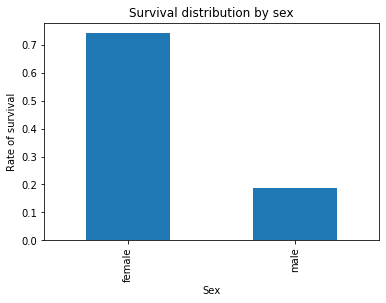

In [59]:
female_survival_rate = final_train.groupby("Sex").mean()["Survived"]['female']
male_survival_rate = final_train.groupby("Sex").mean()["Survived"]["male"]
print("Survival rate by sex.\n Male survival rate: {:0.1%} ".format(male_survival_rate)+"\n Female survival rate: {:0.1%}".format(female_survival_rate))
final_train.groupby("Sex").mean()["Survived"].plot(kind = "bar")
plt.title("Survival distribution by sex")
plt.ylabel("Rate of survival")
plt.xlabel("Sex")
plt.show()



 Male average age: 30.98 
 Female average age: 27.02


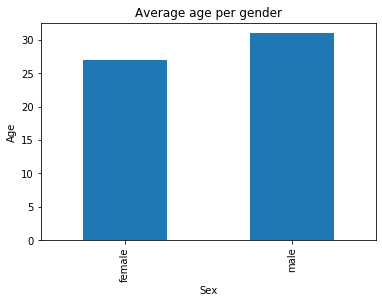

In [60]:
female_avg_age = final_train.groupby("Sex").mean()["Age"]["female"]
male_avg_age = final_train.groupby("Sex").mean()["Age"]["male"]
print("")
print(" Male average age: {:.2f} ".format(male_avg_age)+"\n Female average age: {:.2f}".format(female_avg_age))
final_train.groupby("Sex").mean()["Survived"].plot(kind = "bar")
plt.title("Average age per gender")
plt.ylabel("Age")
plt.xlabel("Sex")
final_train.groupby("Sex").mean()["Age"].plot(kind = "bar")
plt.show()

Survival rate based on where passengers embarkerd


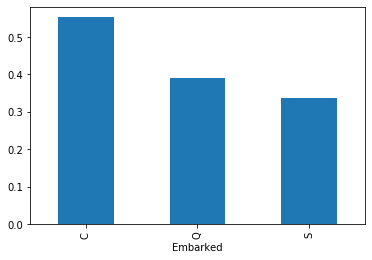

In [61]:
print("Survival rate based on where passengers embarkerd")
final_train.groupby("Embarked").mean()["Survived"].plot(kind = "bar")
plt.show()

Survival rate based on passenger's title


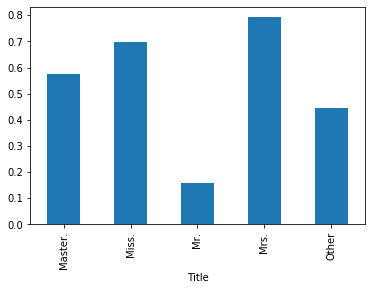

In [62]:
print("Survival rate based on passenger's title")
final_train.groupby("Title").mean()["Survived"].plot(kind = "bar")
plt.show()

Survival rate based on passengers ticket class


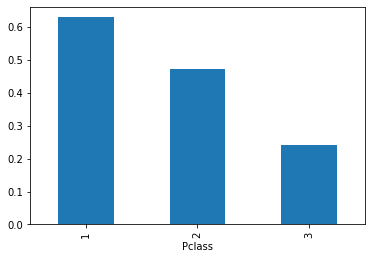

In [63]:
print("Survival rate based on passengers ticket class")
final_train.groupby("Pclass").mean()["Survived"].plot(kind = "bar")
plt.show()

survival rate by passenger sex and class


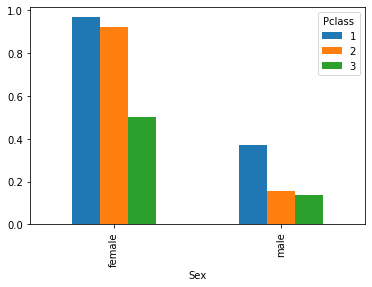

In [64]:
print("survival rate by passenger sex and class")
final_train.groupby(["Sex", 'Pclass']).mean()["Survived"].unstack().plot(kind = 'bar')
plt.show()

In [65]:
final_train["Age"] = final_train['Age'].astype(int)


In [66]:
final_train["Age"].describe()

count    891.000000
mean      29.570146
std       13.910321
min        0.000000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [67]:
final_train["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

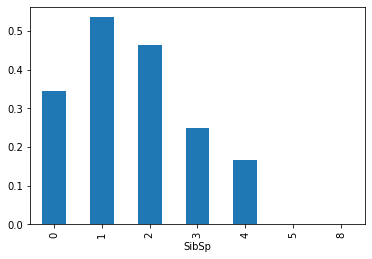

In [68]:
final_train.groupby(["SibSp"]).mean()["Survived"].plot(kind="bar")
plt.show()

In [69]:
final_train["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

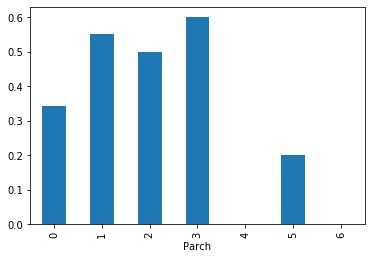

In [70]:
final_train.groupby(["Parch"]).mean()["Survived"].plot(kind="bar")
plt.show()

In [71]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int32
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null object
dtypes: float64(1), int32(1), int64(4), object(3)
memory usage: 66.1+ KB


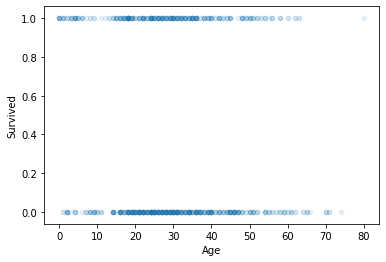

In [72]:
final_train.plot(kind = "scatter", x= "Age", y = "Survived",alpha =0.1)

In [73]:
final_train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [74]:
final_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [75]:
final_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [76]:
final_train["Age"].describe()

count    891.000000
mean      29.570146
std       13.910321
min        0.000000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [77]:
final_train["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [78]:
final_train["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [79]:
final_train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [80]:
final_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [81]:
final_train["Title"].value_counts()

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Other       27
Name: Title, dtype: int64

In [82]:
X_final_train = final_train.drop("Survived", axis =1).copy()
X_final_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,22,1,0,7.2500,S,Mr.
1,1,female,38,1,0,71.2833,C,Mrs.
2,3,female,26,0,0,7.9250,S,Miss.
3,1,female,35,1,0,53.1000,S,Mrs.
4,3,male,35,0,0,8.0500,S,Mr.


In [83]:
cat_cols = ["Sex", "Embarked","Title"]
num_cols = ['Pclass', 'SibSp', 'Parch', 'Fare']

complete_pipe = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

In [84]:
X_final_train_prepared = complete_pipe.fit_transform(X_final_train)
X_final_train_prepared

array([[ 0.82737724,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-1.56610693,  0.43279337, -0.47367361, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.82737724, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.82737724,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56610693, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ]])

In [86]:
X_final_train_prepared.shape

(891, 14)

In [87]:
y_final_train = final_train["Survived"].copy()
y_final_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [88]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(max_iter= 5, tol=-np.infty, random_state= 42)
sgd_classifier.fit(X_final_train_prepared, y_final_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [95]:
# acc_sgd = round(sgd_classifier.score(X_final_train_prepared, y_final_train) * 100, 2)
# print (acc_sgd)
cross_val_score(sgd_classifier, X_final_train_prepared, y_final_train, cv=5, scoring="accuracy")

array([0.74860335, 0.77094972, 0.78651685, 0.7247191 , 0.84745763])

In [98]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_final_train_prepared, y_final_train, cv = 5)

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_final_train, y_train_pred)

array([[455,  94],
       [106, 236]], dtype=int64)

In [101]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_final_train_prepared, y_final_train, cv = 3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_final_train, y_train_pred)

array([[250, 299],
       [ 76, 266]], dtype=int64)

In [100]:
y_perfect_pred = y_final_train
confusion_matrix(y_final_train, y_perfect_pred)

array([[549,   0],
       [  0, 342]], dtype=int64)

# Split the train dataframe into a test and train data set
Test dataset = Rows where age is null
Train dataset = Rows where age is known

# Address Missing values

Notice that there are a few of the columns whit missing value.
## Age 
Potentially could be a key indicator has a few null values.
- Option-1:
Impute a mean or median value. 
- Option-2:
Create a model to predict age and use that for the actual project.

## Cabin
Similarly, Cabin is missing some values. Since cabin has significantly higher count of missing value, and there may not be an easy way to impute 
- Option-1:
Drop the catagory 
- Option-2:
create another catagory where we assign cabin known or unknown binary value 

## Embarked
Embarked is also missing a couple of values. Since this is missing only two values, we may just impute with mode value. 

# Explore and visualize calculate coorelation 


# Drop Labels from train set